<a href="https://colab.research.google.com/github/iamdanialkamali/TripletLossForMNIST/blob/master/triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

VECTOR_SIZE = 32


In [ ]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [ ]:
import random

def data_generator(x, y, batch_size=32):
  n_classes = 10

  class_ids = [None] * n_classes
  for n in range(n_classes):
    class_ids[n] = np.where(y == n)[0]

  while True:
    X_batch_0 = np.empty((batch_size, 32, 32, 3), dtype=np.float32)
    X_batch_1 = np.empty((batch_size, 32, 32, 3), dtype=np.float32)
    X_batch_2 = np.empty((batch_size, 32, 32, 3), dtype=np.float32)

    for i in range(batch_size):
      tgt_class = random.randint(0, n_classes - 1)
      neg_class = random.randint(0, n_classes - 2)
      if neg_class == tgt_class:
        neg_class = n_classes - 1
      a = random.randint(0, class_ids[tgt_class].size - 1)
      p = random.randint(0, class_ids[tgt_class].size - 2)
      if p == a:
        p = class_ids[tgt_class].size - 1
      n = random.randint(0, class_ids[neg_class].size - 1)
      idx_a = class_ids[tgt_class][a]
      idx_p = class_ids[tgt_class][p]
      idx_n = class_ids[neg_class][n]
      X_batch_0[i] = x[idx_a] / 256
      X_batch_1[i] = x[idx_p] / 256
      X_batch_2[i] = x[idx_n] / 256

    yield [X_batch_0, X_batch_1, X_batch_2], np.empty((batch_size, VECTOR_SIZE * 3))


In [ ]:
gen = data_generator(x_train, y_train)
X_list, _ = next(gen)

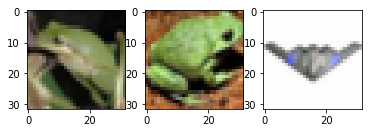

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

INDEX = 16
fig, axes = plt.subplots(1, 3)
for i, ax in enumerate(axes):
  ax.imshow(X_list[i][INDEX])
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

img_width = 32
img_height = 32
img_colors = 3

margin = 1.0

def triplet_loss(y_true, y_pred):
    """ ignore y_true
    """
    anchor_vec = y_pred[:, :VECTOR_SIZE]
    positive_vec = y_pred[:, VECTOR_SIZE:2*VECTOR_SIZE]
    negative_vec = y_pred[:, 2*VECTOR_SIZE:]
    d1 = keras.losses.cosine_proximity(anchor_vec, positive_vec)
#     d1 = K.print_tensor(d1, message='d1=')
    d2 = keras.losses.cosine_proximity(anchor_vec, negative_vec)
#     d2 = K.print_tensor(d2, message='d2=')
    return K.clip(d2 - d1 + margin, 0, None)

def cos_sim_pos(y_true, y_pred):
    """ Cosine similarity between anchor and positive sample
        Higher value is better.
    """
    anchor_vec = y_pred[:, :VECTOR_SIZE]
    positive_vec = y_pred[:, VECTOR_SIZE:2*VECTOR_SIZE]
    d1 = keras.losses.cosine_proximity(anchor_vec, positive_vec)
    return d1

def cos_sim_neg(y_true, y_pred):
    """ Cosine similarity between anchor and negative sample
        Lower value is better.
    """
    anchor_vec = y_pred[:, :VECTOR_SIZE]
    negative_vec = y_pred[:, 2*VECTOR_SIZE:]
    d2 = keras.losses.cosine_proximity(anchor_vec, negative_vec)
    return d2


def make_image_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_width, img_height, img_colors)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
#   model.add(Dropout(0.5))
  model.add(Dense(VECTOR_SIZE))
  return model

def make_image_model_small():
  inp = Input(shape=(img_width, img_height, img_colors))
  l1 = Conv2D(16, (3, 3))(inp)
  l1 = MaxPooling2D()(l1)
  l2 = Conv2D(32, (2, 2))(l1)
  l2 = MaxPooling2D()(l2)
  l3 = Conv2D(64, (2, 2))(l2)
  l3 = MaxPooling2D()(l3)
  conv_out = Flatten()(l3)
  out = Dense(VECTOR_SIZE)(conv_out)
  model = Model(inp, out)
  return model

def make_siamese_model(img_model):
  anchor = Input(shape=(img_width, img_height, img_colors))
  positive = Input(shape=(img_width, img_height, img_colors))
  negative = Input(shape=(img_width, img_height, img_colors))
  anchor_vec = img_model(anchor)
  positive_vec = img_model(positive)
  negative_vec = img_model(negative)
  vecs = Concatenate(axis=1, name='vectors')([anchor_vec, positive_vec, negative_vec])
  model = Model([anchor, positive, negative], vecs)
  model.compile('adam', triplet_loss, metrics=[cos_sim_pos, cos_sim_neg])
  return model

tf.set_random_seed(42)
img_model = make_image_model()
train_model = make_siamese_model(img_model)
img_model.summary()
train_model.summary()

W0624 07:59:28.298809 139782001362816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [ ]:
# generate a single batch
random.seed(42)
gen = data_generator(x_train, y_train, batch_size=1)
x_b0, y_b0 = next(gen)


In [ ]:
# debug code to make sure that cosine similarity matches model metrics / loss
from sklearn.metrics.pairwise import cosine_similarity
output = train_model.predict(x_b0)
v1 = output[:, :VECTOR_SIZE]
v2 = output[:, VECTOR_SIZE:2*VECTOR_SIZE]
v3 = output[:, 2*VECTOR_SIZE:]
print('pos', cosine_similarity(v1, v2))
print('neg', cosine_similarity(v1, v3))

pos [[0.9334991]]
neg [[0.94116354]]


In [ ]:
train_model.evaluate(x_b0)

1/1 [==============================] - 0s 112ms/sample - loss: 1.0077 - cos_sim_pos: 0.9335 - cos_sim_neg: 0.9412


[1.007664442062378, 0.93349916, 0.94116354]

In [ ]:
history = train_model.fit_generator(
    data_generator(x_train, y_train, batch_size=64), validation_data=data_generator(x_test, y_test, batch_size=3),
    steps_per_epoch=1000, validation_steps=200,
    epochs=30)

Epoch 1/30


W0624 07:59:31.270154 139782001362816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1000/1000 [==============================] - 42s 42ms/step - loss: 0.8735 - cos_sim_pos: 0.6894 - cos_sim_neg: 0.5191 - val_loss: 0.6840 - val_cos_sim_pos: 0.5385 - val_cos_sim_neg: 0.0629
Epoch 2/30
1000/1000 [==============================] - 40s 40ms/step - loss: 0.6487 - cos_sim_pos: 0.5370 - cos_sim_neg: 0.0404 - val_loss: 0.6393 - val_cos_sim_pos: 0.5484 - val_cos_sim_neg: 0.0318
Epoch 3/30
1000/1000 [==============================] - 40s 40ms/step - loss: 0.5934 - cos_sim_pos: 0.5569 - cos_sim_neg: 0.0074 - val_loss: 0.5878 - val_cos_sim_pos: 0.5538 - val_cos_sim_neg: 0.0054
Epoch 4/30
1000/1000 [==============================] - 39s 39ms/step - loss: 0.5413 - cos_sim_pos: 0.5785 - cos_sim_neg: -0.0163 - val_loss: 0.4945 - val_cos_sim_pos: 0.6086 - val_cos_sim_neg: -0.0286
Epoch 5/30
1000/1000 [==============================] - 39s 39ms/step - loss: 0.4874 - cos_sim_pos: 0.6062 - cos_sim_neg: -0.0348 - val_loss: 0.4686 - val_cos_sim_pos: 0.5917 - val_cos_sim_neg: -0.0642
Epoch 6

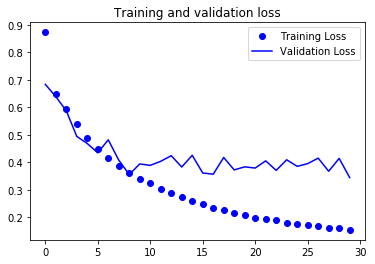

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()

plt.plot(range(len(loss)), loss, 'bo', label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# use image model to generate image vectors
train_vecs = img_model.predict(x_train)
test_vecs = img_model.predict(x_test)

from sklearn.metrics.pairwise import cosine_similarity
y_sim = cosine_similarity(test_vecs, train_vecs)
y_max = np.argmax(y_sim, axis=1)

y_pred = y_train[y_max]

In [ ]:
from sklearn.metrics import classification_report
class_names = [str(i) for i in range(10)]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1000
           1       0.68      0.68      0.68      1000
           2       0.46      0.42      0.44      1000
           3       0.31      0.33      0.32      1000
           4       0.44      0.43      0.43      1000
           5       0.38      0.40      0.39      1000
           6       0.72      0.69      0.70      1000
           7       0.70      0.66      0.68      1000
           8       0.68      0.70      0.69      1000
           9       0.61      0.62      0.62      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



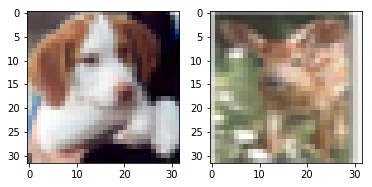

In [ ]:
# Examine prediction for a specific value.
INDEX = 16
fig, axes = plt.subplots(1, 2)
axes[0].imshow(x_test[INDEX])
axes[1].imshow(x_train[y_max[INDEX]])
plt.show()

In [ ]:
# classes of the top K vectors most similar to test
print('y_true:', y_test[INDEX])
k = 10
top_k = np.argpartition(y_sim[INDEX], -k)[-k:]
y_train[top_k]


y_true: [5]


array([[3],
       [3],
       [3],
       [5],
       [5],
       [5],
       [3],
       [5],
       [4],
       [5]], dtype=uint8)